<a href="https://colab.research.google.com/github/INU-IndEng/final_project_1-leeminjae007/blob/main/final_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project
# “Artificial Intelligence - Wind Power Generation Forecasting”

##**Load libraries**

In [ ]:
# Import all your libraries only in this cell
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#Make Numpy printout easier to read
np.set_printoptions(precision=3, suppress=True)

In [ ]:
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import datetime
from tensorboard.plugins.hparams import api as hp

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
from keras.regularizers import l2
import keras.backend as k
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint

**Load datasets**

##second way

In [ ]:
#1 .- Download data from kaggle website
#2 .- Load data to drive.google.com
# connect goolge drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load dataset
train_df = pd.read_csv("/content/drive/MyDrive/2022 AI/2022aifpc/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/2022 AI/2022aifpc/test.csv")

In [ ]:
#check the dataset
dataset = train_df.copy()
dataset.tail()

,ID,Date,Time,Wind_Energy_1,Wind_Energy_2,Wind_Energy_3
25148,25149,12/31/2020,20:00,0.0,0.3,1.6
25149,25150,12/31/2020,21:00,0.0,0.0,1.2
25150,25151,12/31/2020,22:00,0.0,0.4,2.1
25151,25152,12/31/2020,23:00,0.0,0.0,2.2
25152,25153,12/31/2020,24:00:00,0.0,0.0,2.6


In [ ]:
dataset.isna().sum()

ID               0
Date             0
Time             0
Wind_Energy_1    0
Wind_Energy_2    0
Wind_Energy_3    0
dtype: int64

In [ ]:
dataset = dataset.dropna()

#### Preprocess data

In [ ]:
#split the date to month and days
dataset['Month'] = dataset.Date.str.split('/').str[0].astype(float)
dataset['Days'] = dataset.Date.str.split('/').str[1].astype(float)
dataset['Hour'] = dataset.Time.str.split(':').str[0].astype(float)

In [ ]:
#check the dataset
dataset.drop(columns = ['Date', 'Time', 'ID'], inplace = True)
dataset.tail()

,Wind_Energy_1,Wind_Energy_2,Wind_Energy_3,Month,Days,Hour
25148,0.0,0.3,1.6,12.0,31.0,20.0
25149,0.0,0.0,1.2,12.0,31.0,21.0
25150,0.0,0.4,2.1,12.0,31.0,22.0
25151,0.0,0.0,2.2,12.0,31.0,23.0
25152,0.0,0.0,2.6,12.0,31.0,24.0


In [ ]:
## Split features
train_features = dataset.copy()

train_labels = train_features[['Wind_Energy_1','Wind_Energy_2','Wind_Energy_3']].copy()
train_features = train_features.drop(['Wind_Energy_1','Wind_Energy_2','Wind_Energy_3'],
                                     axis = 1)

##Normalization

In [ ]:
#calcultae mean and std
dataset.describe().transpose()[['mean','std']]

,mean,std
Wind_Energy_1,15.398925,18.931922
Wind_Energy_2,8.536261,9.958963
Wind_Energy_3,12.075927,11.549401
Month,6.758399,3.339400
Days,15.834016,8.803905
Hour,12.500457,6.922566


In [ ]:
#The first step is to create the norm layer
normalizer = tf.keras.layers.Normalization(axis=-1)

In [ ]:
#fit the preprocessing layer
normalizer.adapt(np.array(train_features))

In [ ]:
print(normalizer.mean.numpy())

[[ 6.758 15.834 12.5  ]]


In [ ]:
first = np.array(train_features[:1])

with np.printoptions(precision =2, suppress = True):
  print('First example: ',first)
  print()
  print('Normalized: ', normalizer(first).numpy())

First example:  [[ 2. 17. 24.]]

Normalized:  [[-1.42  0.13  1.66]]


## Linear regression with three variables

In [ ]:
#Store three variables as three_var
three_var = np.array(train_features[['Hour','Month','Days']])

three_var_normalizer = layers.Normalization(input_shape=[3,], axis = None)

three_var_normalizer.adapt(three_var)

In [ ]:
#Deep learning model
three_var_model = tf.keras.Sequential([
          #First layer
          three_var_normalizer,
          #hidden layers
          layers.Dense(units = 30, activation = 'relu'),#relu,....dont use sigmoid
          layers.Dense(units = 30, activation = 'tanh'),
          layers.Dense(units = 30, activation = 'tanh'),
           #last layer
          layers.Dense(units=3)
])
three_var_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 3)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 30)                120       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dense_3 (Dense)             (None, 3)                 93        
                                                                 
Total params: 2,076
Trainable params: 2,073
Non-trainable params: 3
______________________________________________________

In [ ]:
#Compile the model using Adam and Mse(and using metrics)
three_var_model.compile(
    optimizer = tf.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
    loss = 'mean_squared_error',
    metrics = ['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#Adjust hyperparameters
log_dir = "logs/fit/DNN_three" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq = 1
)
hparams_callback = hp.KerasCallback(log_dir, {
    'num_ANN_units_1': 30,
    'ANN_activation' : 'tanh',
    'num_ANN_units_2': 30,
    'num_ANN_units_3': 30,
    'num_linear_units': 3,
})

In [ ]:
#Use the earlystopping callback to learn the data
history = three_var_model.fit(
    three_var,
    train_labels,
    epochs = 100,
    verbose = 1,
    validation_split = 0.15,
    callbacks = [EarlyStopping(
        monitor = 'val_accuracy',
        mode = 'max',
        patience = 10
    ),
    ModelCheckpoint(filepath='best_model.h5', monitor = 'val_accuracy',
                    mode = 'max', save_best_only=True)
    ])

Epoch 1/100
669/669 [==============================] - 2s 2ms/step - loss: 139.4021 - accuracy: 0.6030 - val_loss: 162.7695 - val_accuracy: 0.5804
Epoch 2/100
669/669 [==============================] - 1s 2ms/step - loss: 139.2833 - accuracy: 0.6030 - val_loss: 163.2589 - val_accuracy: 0.5807
Epoch 3/100
669/669 [==============================] - 1s 2ms/step - loss: 139.2763 - accuracy: 0.6032 - val_loss: 163.1622 - val_accuracy: 0.5812
Epoch 4/100
669/669 [==============================] - 1s 2ms/step - loss: 139.2734 - accuracy: 0.6037 - val_loss: 163.0139 - val_accuracy: 0.5810
Epoch 5/100
669/669 [==============================] - 1s 2ms/step - loss: 139.2067 - accuracy: 0.6040 - val_loss: 162.6696 - val_accuracy: 0.5799
Epoch 6/100
669/669 [==============================] - 1s 2ms/step - loss: 139.1694 - accuracy: 0.6028 - val_loss: 162.8032 - val_accuracy: 0.5802
Epoch 7/100
669/669 [==============================] - 1s 2ms/step - loss: 139.1233 - accuracy: 0.6029 - val_loss: 162

In [ ]:
#Check the accuracy and val_accuracy using plot
def plot_loss(history):
  plt.plot(history.history['accuracy'], label='acc')
  plt.plot(history.history['val_accuracy'],label='val_acc')
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid(True)

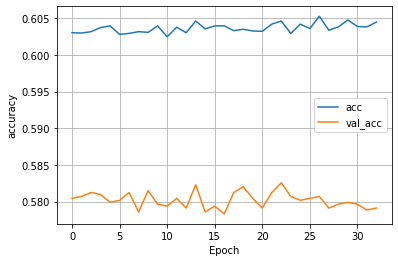

In [ ]:
 plot_loss(history)

In [ ]:
#Check the loss and val_loss using plot
def plot_loss(history):
  plt.plot(history.history['loss'], label='acc')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.legend(loc='lower left')
  plt.grid(True)

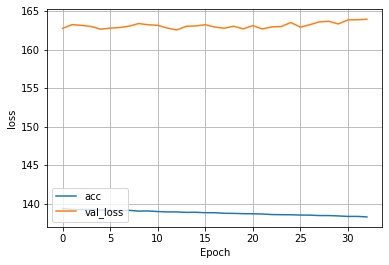

In [ ]:
 plot_loss(history)

In [ ]:
#Check the dataframe
hist =pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
28,138.489471,0.603835,163.689301,0.579645,28
29,138.443115,0.604771,163.343842,0.579910,29
30,138.378281,0.603882,163.874008,0.579645,30
31,138.383713,0.603835,163.889679,0.578850,31
32,138.315414,0.604490,163.956207,0.579115,32


In [ ]:
test_df['Month'] = test_df.Date.str.split('/').str[0].astype(float)
test_df['Days'] = test_df.Date.str.split('/').str[1].astype(float)
test_df['Hour'] = test_df.Time.str.split(':').str[0].astype(float)
test_df = test_df.drop(columns=['Date','Time'])
test_df.tail()

,ID,Month,Days,Hour
6979,32133,10.0,18.0,20.0
6980,32134,10.0,18.0,21.0
6981,32135,10.0,18.0,22.0
6982,32136,10.0,18.0,23.0
6983,32137,10.0,18.0,24.0


In [ ]:
#The learned test_df is stored in the DNN_three_df.
test_features = test_df.copy()
DNN_three_df = three_var_model.predict(test_features[['Hour','Month','Days']])

In [ ]:
# The path of the csv file to store the deep learning results is specified and generated.
result = pd.DataFrame(DNN_three_df,
                      columns = ['Wind_Energy_1','Wind_Energy_2','Wind_Energy_3'],
                      index = test_df['ID'])
result.to_csv('/content/drive/MyDrive/2022 AI/2022aifpc/201801361-1.csv')